In [1]:

!pip install -q torch torchvision transformers matplotlib

In [2]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)


Device being used: cuda


In [4]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


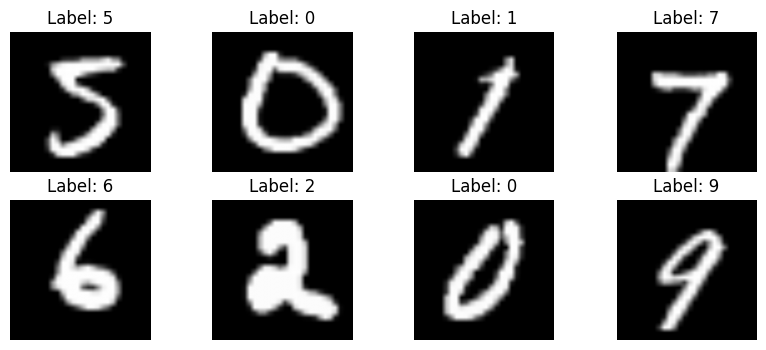

In [5]:

images, labels = next(iter(train_loader))
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [9]:

from transformers import ViTForImageClassification, ViTImageProcessor


processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=10,
    ignore_mismatched_sizes=True
model.to(device)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [10]:

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()


In [11]:

epochs = 3  # enough for MNIST
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Use processor and avoid rescaling (images already in [0,1])
        inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/3, Loss: 0.0681


KeyboardInterrupt: 

In [12]:

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
        outputs = model(**inputs)
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {100*correct/total:.2f}%")

✅ Test Accuracy: 99.22%


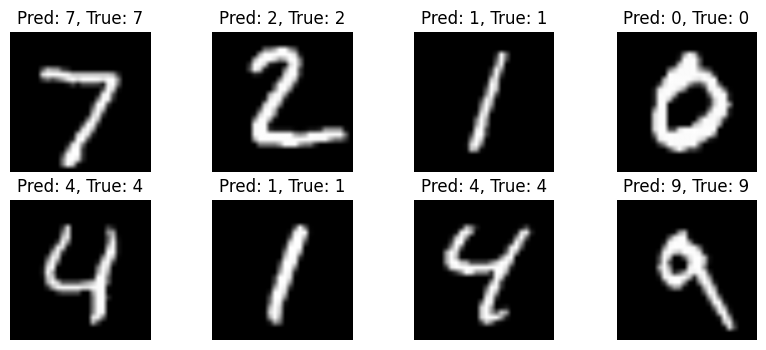

In [13]:

images, labels = next(iter(test_loader))
inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
outputs = model(**inputs)
preds = outputs.logits.argmax(dim=-1).cpu()

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Pred: {preds[i].item()}, True: {labels[i]}")
    plt.axis('off')
plt.show()


In [14]:

torch.save(model.state_dict(), "vit_mnist_tiny.pth")
print("Model saved as vit_mnist_tiny.pth")

Model saved as vit_mnist_tiny.pth
